In [5]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber,ElectronicEnergy
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.results import ElectronicStructureResult
import numpy as np

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

properties = driver.run()
particle_number = properties.get_property(ParticleNumber)

EE=properties.get_property(ElectronicEnergy)
result = ElectronicStructureResult()
result.eigenenergies = np.asarray([-1])
result.computed_energies = np.asarray([-1])

EE.interpret(result)
result.nuclear_repulsion_energy

0.7199689944489797

In [9]:
print(result._eigenstates)

None


In [6]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")
print(PN_property)

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
# transformer = ActiveSpaceTransformer(
#     num_electrons=2, #how many electrons we have in our active space
#     num_molecular_orbitals=2, #how many orbitals we have in our active space
# )

ParticleNumber:
	4 SOs
	1 alpha electrons
		orbital occupation: [1. 0.]
	1 beta electrons
		orbital occupation: [1. 0.]


In [11]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

problem = ElectronicStructureProblem(driver, [transformer])

second_q_ops = problem.second_q_ops() # this calls driver.run() internally

hamiltonian = second_q_ops[0]

print(hamiltonian)

Fermionic Operator
register length=4, number terms=36
  -1.2563390730032498 * ( +_0 -_0 )
+ -0.47189600728114245 * ( +_1 -_1 )
+ -1.2563390730032498 * ( +_2 -_2 )
+ -0.47189600728114245 * ( +_3 -_3 )
+ -0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ -0. ...


In [13]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper)

qubit_op = converter.convert(hamiltonian)
print(qubit_op)

-0.8105479805373279 * IIII
+ 0.1721839326191554 * IIIZ
- 0.22575349222402372 * IIZI
+ 0.17218393261915543 * IZII
- 0.2257534922240237 * ZIII
+ 0.12091263261776627 * IIZZ
+ 0.16892753870087907 * IZIZ
+ 0.045232799946057826 * YYYY
+ 0.045232799946057826 * XXYY
+ 0.045232799946057826 * YYXX
+ 0.045232799946057826 * XXXX
+ 0.1661454325638241 * ZIIZ
+ 0.1661454325638241 * IZZI
+ 0.17464343068300453 * ZIZI
+ 0.12091263261776627 * ZZII


In [14]:
from qiskit_nature.circuit.library import HartreeFock

particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_spin_orbitals = particle_number.num_spin_orbitals
num_particles = particle_number.num_particles


init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


In [15]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "UCCSD"


# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cz'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz.decompose())

     ┌───┐┌───────────────────────────────────┐»
q_0: ┤ X ├┤0                                  ├»
     └───┘│                                   │»
q_1: ─────┤1                                  ├»
     ┌───┐│  exp(-it (IIXY + IIYX))(1.0*t[0]) │»
q_2: ┤ X ├┤2                                  ├»
     └───┘│                                   │»
q_3: ─────┤3                                  ├»
          └───────────────────────────────────┘»
«     ┌───────────────────────────────────┐»
«q_0: ┤0                                  ├»
«     │                                   │»
«q_1: ┤1                                  ├»
«     │  exp(-it (XYII + YXII))(1.0*t[1]) │»
«q_2: ┤2                                  ├»
«     │                                   │»
«q_3: ┤3                                  ├»
«     └───────────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                            

In [16]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'L_BFGS_B'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

In [17]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# The targeted electronic energy for H2 is -1.85336 Ha
# Check with your VQE result.

Exact electronic energy -1.8572750302023873
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [18]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 24,
    'eigenstate': array([-3.13271536e-17+1.54237193e-16j,  2.15172166e-16-2.49748005e-16j,
        1.42964097e-18-5.63903285e-18j, -6.75415086e-17-5.64974152e-17j,
       -4.25531988e-17-5.92660725e-17j,  9.93760474e-01-1.15876133e-15j,
        1.30438923e-07-2.41840216e-17j,  7.02651770e-17-1.32332666e-16j,
        1.72899260e-17+4.59520904e-17j,  1.87055938e-07+9.95572832e-17j,
       -1.11535290e-01+1.44198265e-16j,  1.20966489e-17-9.82849261e-17j,
        1.50683138e-17+3.78152195e-17j, -1.82095449e-16-1.41897518e-16j,
        3.44120421e-17+3.59943306e-17j, -2.73963026e-17-8.90150948e-17j]),
    'eigenvalue': (-1.8572750302016325+0j),
    'optimal_parameters': {   ParameterVectorElement(t[2]): 0.11176784662283079,
                              ParameterVectorElement(t[1]): -1.8705593811201536e-07,
                              ParameterVectorElement(t[0]): -1.3043892290202572e-07},
    'optimal_point': array([-1.

,optimizer,ansatz,rotation blocks,entanglement_blocks,entanglement,repetitions,# of qubits,# of parameters,# of CNOTs,# of evaluations,error (mHa)
0,L_BFGS_B,UCCSD,None,None,None,None,4,3,56,24,7.547296e-10


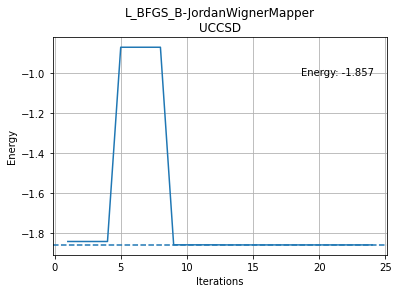

In [19]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']

energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f}).png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2o.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', 'rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', '# of qubits', '# of parameters', '# of CNOTs', '# of evaluations', 'error (mHa)']]

In [20]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import GroundStateEigensolver, QEOM, VQEUCCFactory

# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
solver = VQEUCCFactory(quantum_instance)
gsc = GroundStateEigensolver(converter, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver
qeom_excited_states_calculation = QEOM(gsc, "sd")

qeom_results = qeom_excited_states_calculation.solve(problem)

print(qeom_results)

/home/justids/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: VQEUCCFactory Constructor: quantum_instance is no longer a positional argument as of version 0.4 and will be removed no sooner than 3 months after the release. Instead use it as a keyword argument
  


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -1.244586758556
> Total excited state energy (Hartree): -0.524617764107
  2: 
* Electronic excited state energy (Hartree): -0.882724358957
> Total excited state energy (Hartree): -0.162755364508
  3: 
* Electronic excited state energy (Hartree): -0.224913461551
> Total excited state energy (Hartree): 0.495055532898
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894842]
    - computed part:      [0.0  0.0  1.38894842]
    - ActiveSpaceTra